## ThinkDSP

This notebook contains code examples from Chapter 2: Harmonics

Copyright 2015 Allen Downey

License: [Creative Commons Attribution 4.0 International](http://creativecommons.org/licenses/by/4.0/)

In [1]:
# Get thinkdsp.py
import numpy as np
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

## Waveforms and harmonics

Create a triangle signal and plot a 3 period segment.

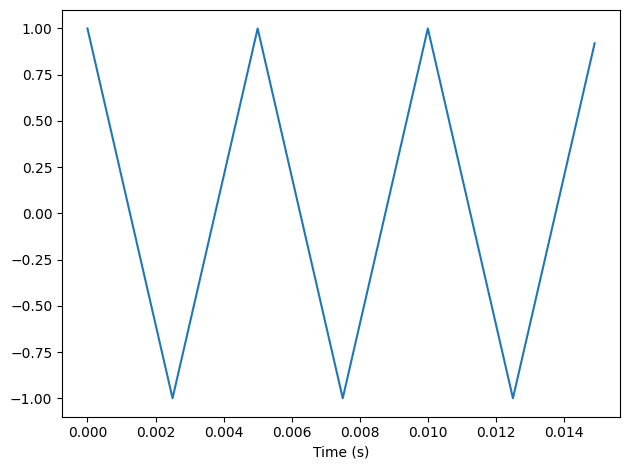

In [2]:
from thinkdsp import TriangleSignal
from thinkdsp import decorate

signal = TriangleSignal(200)
duration = signal.period*3
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a wave and play it.

In [3]:
wave = signal.make_wave(duration=0.5, framerate=10000)
wave.apodize()
wave.make_audio()

Compute its spectrum and plot it.

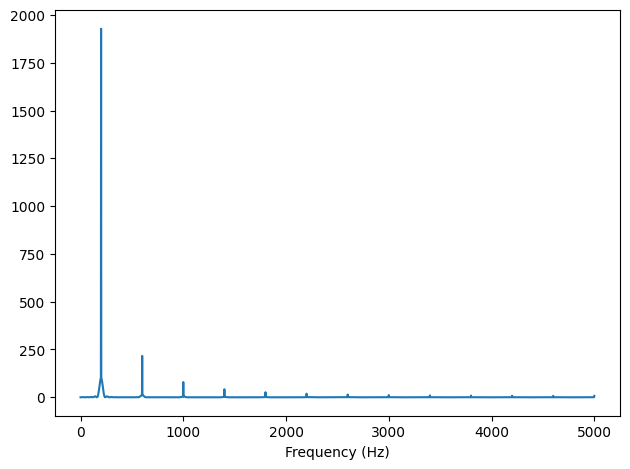

In [4]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Make a square signal and plot a 3 period segment.

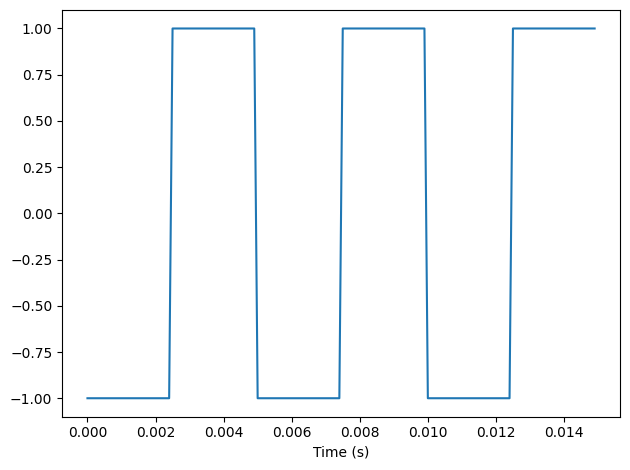

In [5]:
from thinkdsp import SquareSignal

signal = SquareSignal(200)
duration = signal.period*3
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a wave and play it.

In [6]:
wave = signal.make_wave(duration=1, framerate=10000)
wave.apodize()
wave.make_audio()

Compute its spectrum and plot it.

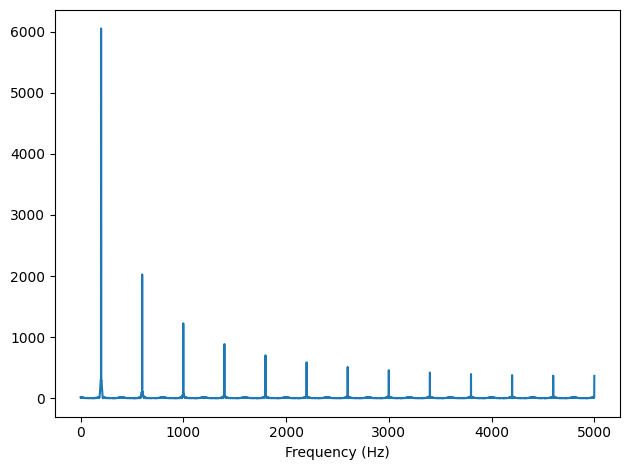

In [7]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

Create a sawtooth signal and plot a 3 period segment.

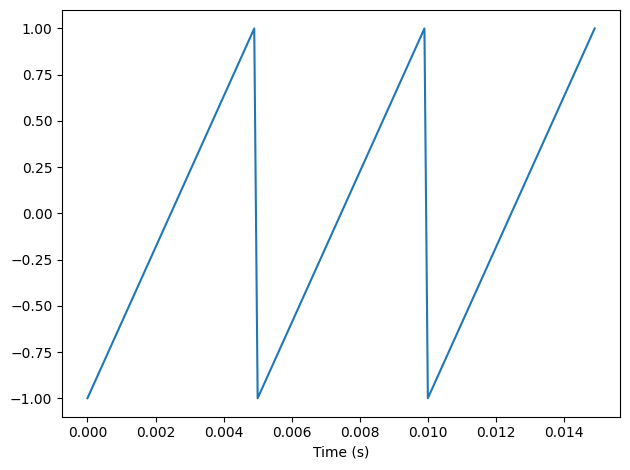

In [8]:
from thinkdsp import SawtoothSignal

signal = SawtoothSignal(200)
duration = signal.period*3
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a wave and play it.

In [9]:
wave = signal.make_wave(duration=0.5, framerate=10000)
wave.apodize()
wave.make_audio()

Compute its spectrum and plot it.

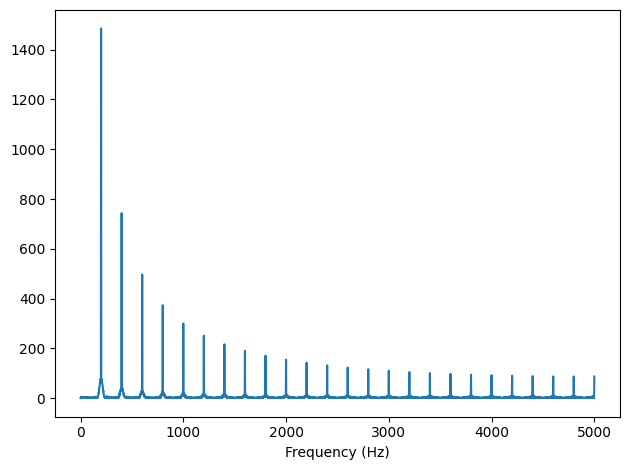

In [10]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

### Aliasing

Make a cosine signal at 4500 Hz, make a wave at framerate 10 kHz, and plot 5 periods.

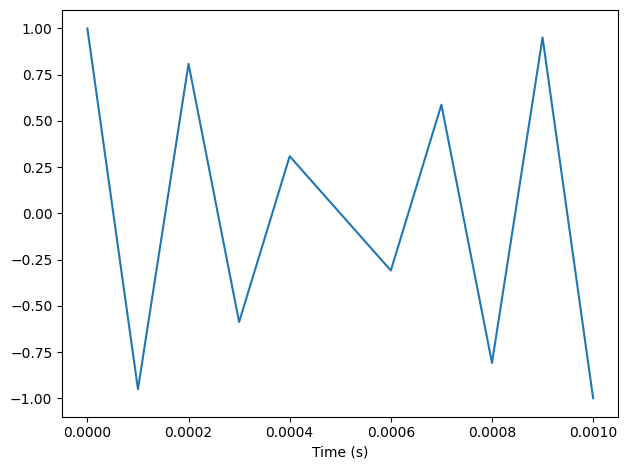

In [13]:
from thinkdsp import CosSignal

signal = CosSignal(4500)
duration = signal.period*5
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a cosine signal at 5500 Hz, make a wave at framerate 10 kHz, and plot the same duration.

With framerate 10 kHz, the folding frequency is 5 kHz, so a 4500 Hz signal and a 5500 Hz signal look exactly the same.

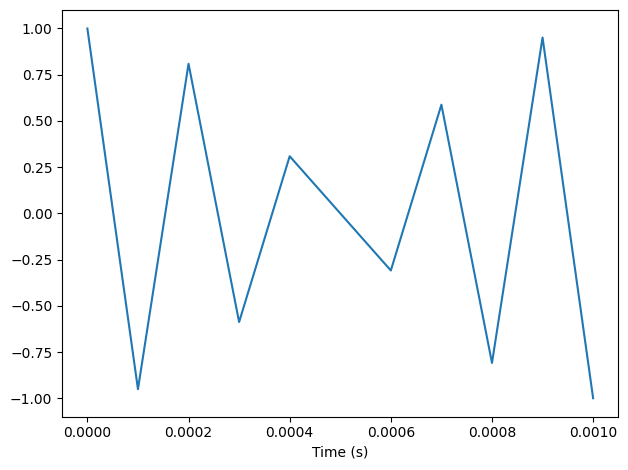

In [12]:
signal = CosSignal(5500)
segment = signal.make_wave(duration, framerate=10000)
segment.plot()
decorate(xlabel='Time (s)')

Make a triangle signal and plot the spectrum.  See how the harmonics get folded.

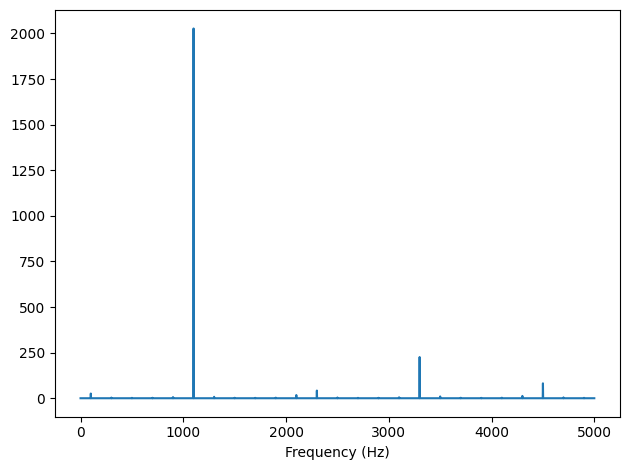

In [16]:
signal = TriangleSignal(1100)
segment = signal.make_wave(duration=0.5, framerate=10000)
spectrum = segment.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

## Amplitude and phase

Make a sawtooth wave.

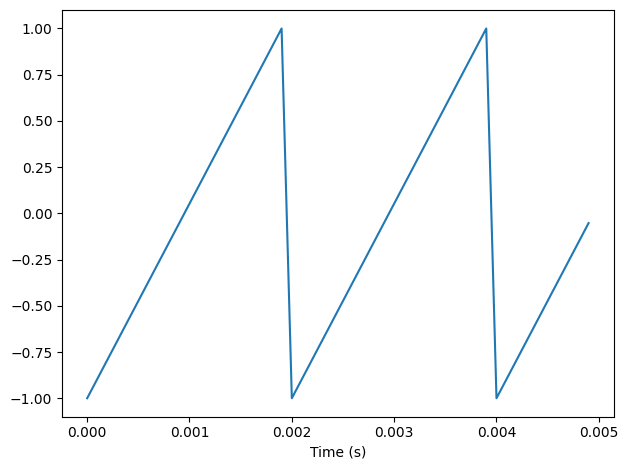

In [17]:
signal = SawtoothSignal(500)
wave = signal.make_wave(duration=1, framerate=10000)
segment = wave.segment(duration=0.005)
segment.plot()
decorate(xlabel='Time (s)')

Play it.

In [18]:
wave.make_audio()

Extract the wave array and compute the real FFT (which is just an FFT optimized for real inputs).

In [19]:
import numpy as np

hs = np.fft.rfft(wave.ys)
hs

array([   0.        +0.j,    0.        -0.j,   -0.        -0.j, ...,
          0.        +0.j,   -0.        +0.j, -526.31578947+0.j],
      shape=(5001,))

Compute the frequencies that match up with the elements of the FFT.

In [20]:
n = len(wave.ys)                 # number of samples
d = 1 / wave.framerate           # time between samples
fs = np.fft.rfftfreq(n, d)
fs

array([   0.,    1.,    2., ..., 4998., 4999., 5000.], shape=(5001,))

Plot the magnitudes vs the frequencies.

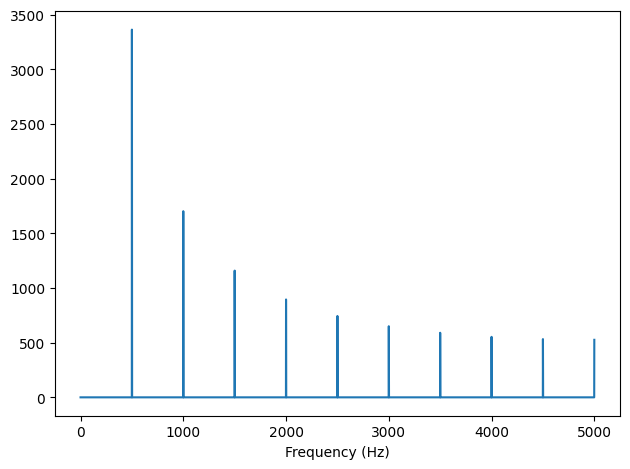

In [21]:
import matplotlib.pyplot as plt

magnitude = np.absolute(hs)
plt.plot(fs, magnitude)
decorate(xlabel='Frequency (Hz)')

Plot the phases vs the frequencies.

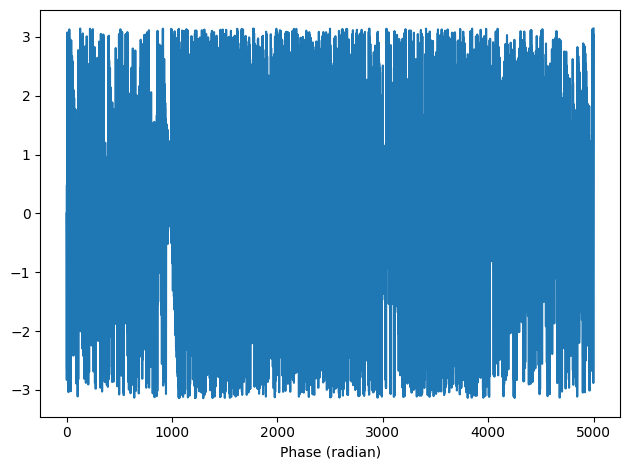

In [22]:
angle = np.angle(hs)
plt.plot(fs, angle)
decorate(xlabel='Phase (radian)')

## What does phase sound like?

Shuffle the phases.

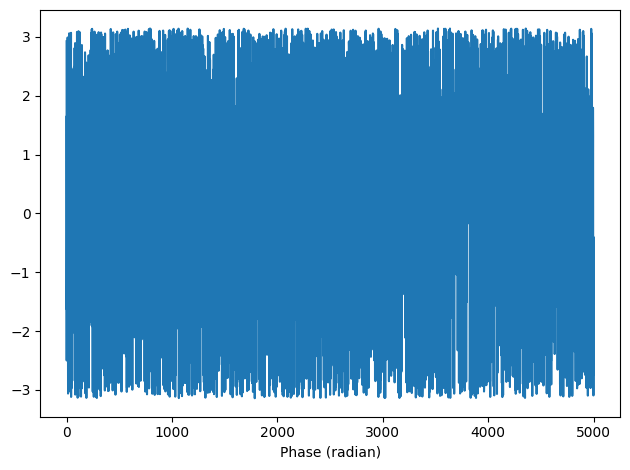

In [23]:
import random
random.shuffle(angle)
plt.plot(fs, angle)
decorate(xlabel='Phase (radian)')

Put the shuffled phases back into the spectrum.  Each element in `hs` is a complex number with magitude $A$ and phase $\phi$, with which we can compute $A e^{i \phi}$

In [24]:
i = complex(0, 1)
spectrum = wave.make_spectrum()
spectrum.hs = magnitude * np.exp(i * angle)

Convert the spectrum back to a wave (which uses irfft).

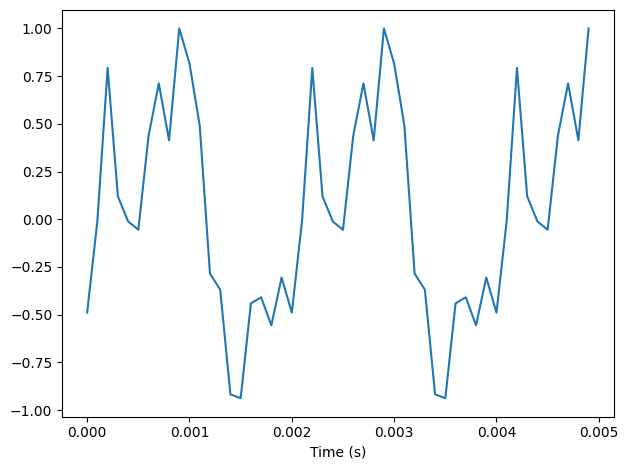

In [25]:
wave2 = spectrum.make_wave()
wave2.normalize()
segment = wave2.segment(duration=0.005)
segment.plot()
decorate(xlabel='Time (s)')

Play the wave with the shuffled phases.

In [26]:
wave2.make_audio()

For comparison, here's the original wave again.

In [27]:
wave.make_audio()

Although the two signals have different waveforms, they have the same frequency components with the same amplitudes.  They differ only in phase.

## Aliasing interaction

The following interaction explores the effect of aliasing on the harmonics of a sawtooth signal.

In [28]:
def view_harmonics(freq, framerate):
    """Plot the spectrum of a sawtooth signal.
    
    freq: frequency in Hz
    framerate: in frames/second
    """
    signal = SawtoothSignal(freq)
    wave = signal.make_wave(duration=0.5, framerate=framerate)
    spectrum = wave.make_spectrum()
    spectrum.plot(color='C0')
    decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')
    display(wave.make_audio())

In [29]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

slider1 = widgets.FloatSlider(min=100, max=10000, value=100, step=100)
slider2 = widgets.FloatSlider(min=5000, max=40000, value=10000, step=1000)
interact(view_harmonics, freq=slider1, framerate=slider2);

interactive(children=(FloatSlider(value=100.0, description='freq', max=10000.0, min=100.0, step=100.0), FloatS…

In [35]:
from thinkdsp import Signal, normalize, unbias

class TriangleSignal(Signal):

    def __init__(self, freq:float=1000, amp:float=1.0, offset:float=0.) -> None:
        self.freq = freq
        self.amp = amp
        self.offset = offset
        
    @property
    def period(self) -> float:
        return 1/self.freq
    
    def evaluate(self, ts: np.ndarray) -> np.ndarray:
        signal, _ = np.modf(ts/self.period)
        signal = unbias(signal)
        signal = normalize(signal, self.amp)
        return signal


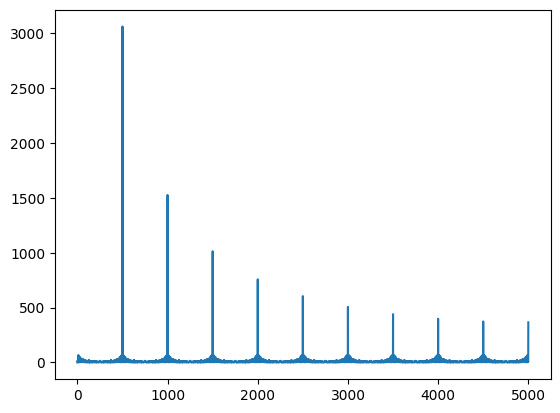

In [47]:
tri = TriangleSignal(500)
tri.make_wave(tri.period*500, framerate=10000).make_spectrum().plot()

In [49]:
sq = SquareSignal(freq=1100)
sq.make_wave(framerate=10000).make_audio()

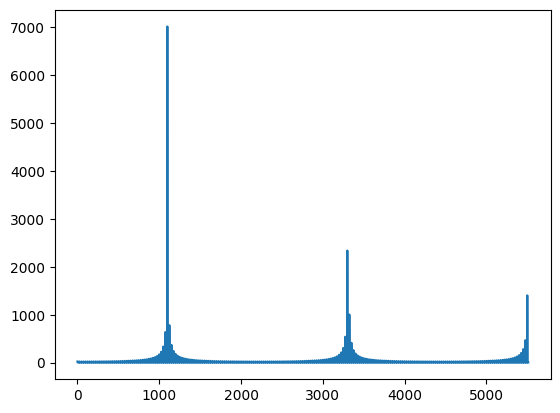

In [50]:
sq.make_wave().make_spectrum().plot()

In [54]:
sq.make_wave(framerate=72000).make_audio()

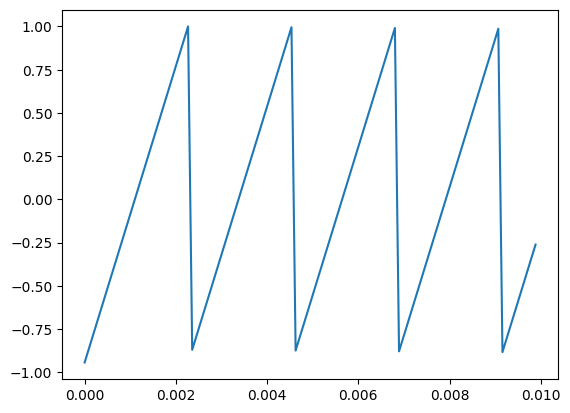

In [55]:
tri = TriangleSignal(freq=440)
tri.make_wave(duration=.01).plot()

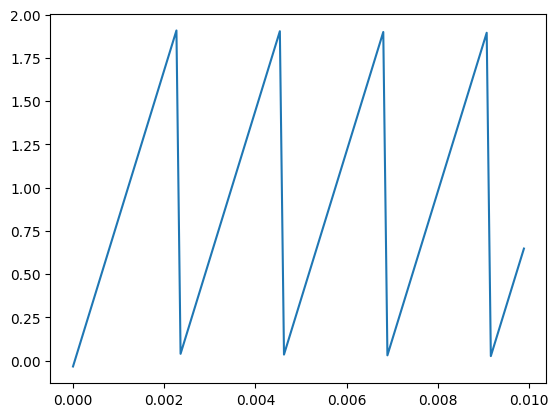

In [59]:
tri_spec = tri.make_wave(duration=.01).make_spectrum()
tri_spec.hs[0] = complex(100,0)
tri_spec.make_wave().plot()

In [162]:
from thinkdsp import Spectrum
def spec_divider(spec: Spectrum) -> Spectrum:
    new_spec = spec.copy()
    new_spec.hs[1:]/=new_spec.fs[1:]
    new_spec.hs[0] = 0
    return new_spec

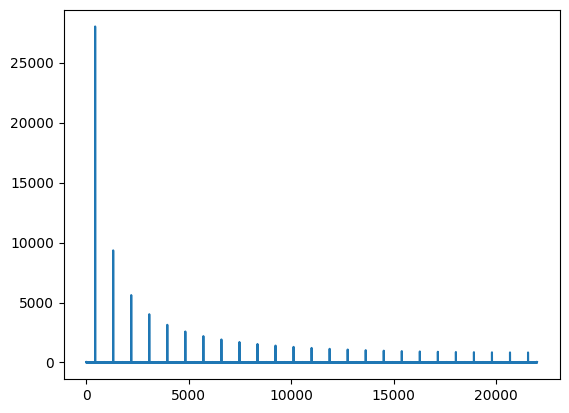

In [114]:
sq = SquareSignal(freq=440).make_wave(framerate=44000)
sq_spec = sq.make_spectrum()
sq_spec.plot()
sq.make_audio()

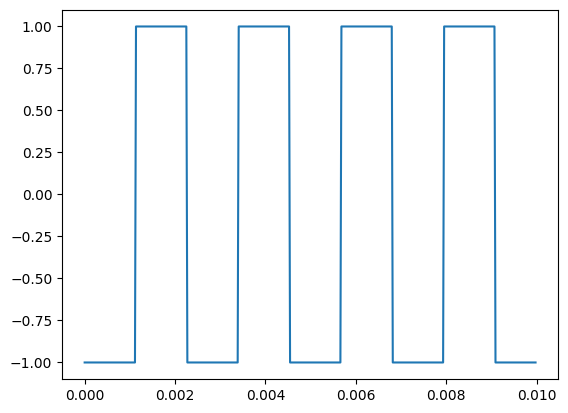

In [110]:
sq.segment(duration=.01).plot()

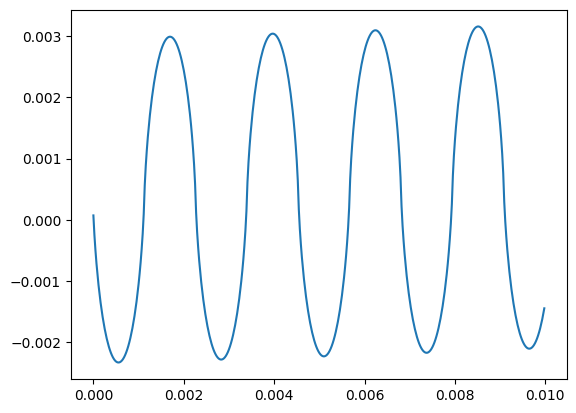

In [136]:
spec_divider(sq.make_spectrum()).make_wave().segment(duration=.01).plot()
spec_divider(sq.make_spectrum()).make_wave().make_audio()

In [163]:
tri = TriangleSignal(freq=440).make_wave(duration=1, framerate=44000)
tri.make_audio()

22001

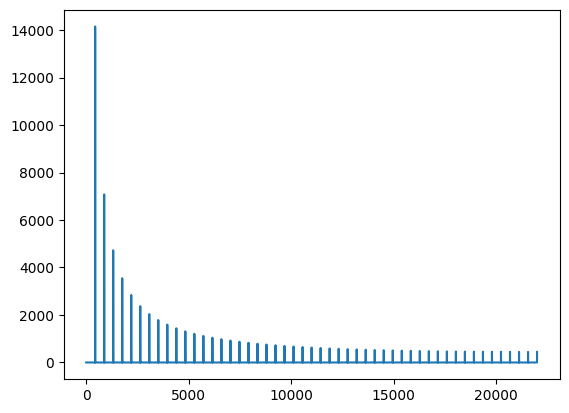

In [164]:
tri_spec = tri.segment(duration=1).make_spectrum()
tri_spec.plot()
len(tri_spec)

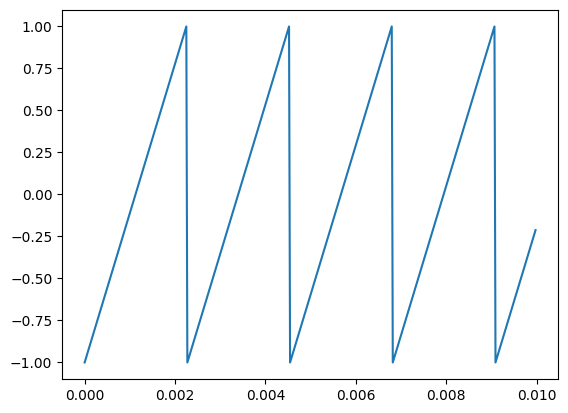

In [167]:
tri_spec.make_wave().segment(duration=.01).plot()

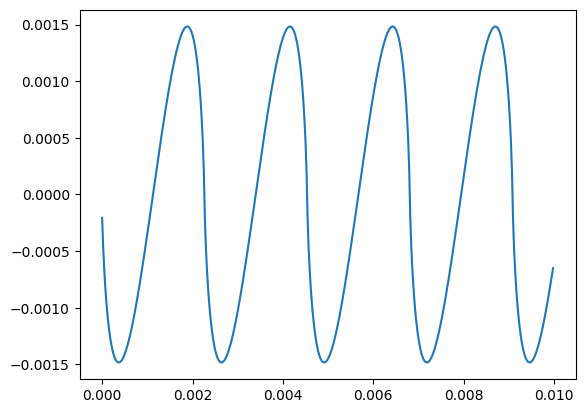

In [170]:
spec_divider(tri_spec).make_wave().segment(duration=.01).plot()
spec_divider(tri_spec).make_wave().make_audio()

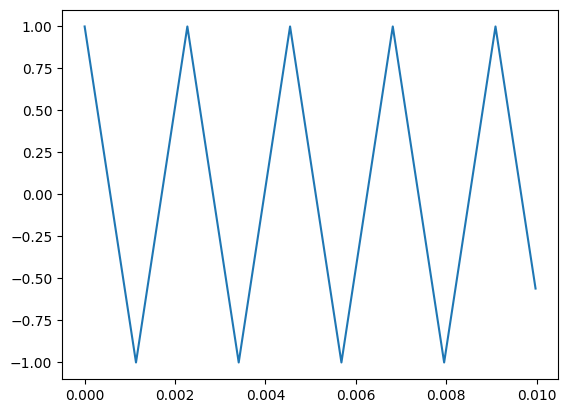

In [168]:
from thinkdsp import TriangleSignal

tri = TriangleSignal().make_wave(framerate=44000)
tri.segment(duration=.01).plot()

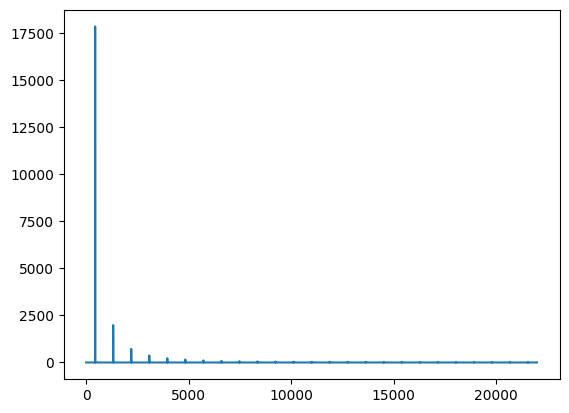

In [171]:
tri_spec = tri.make_spectrum()
tri_spec.plot()

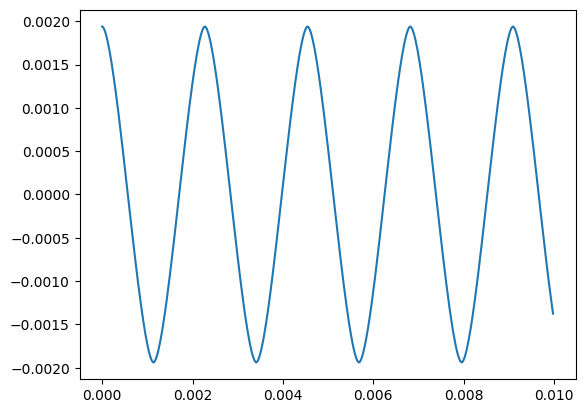

In [173]:
spec_divider(tri_spec).make_wave().segment(duration=.01).plot()

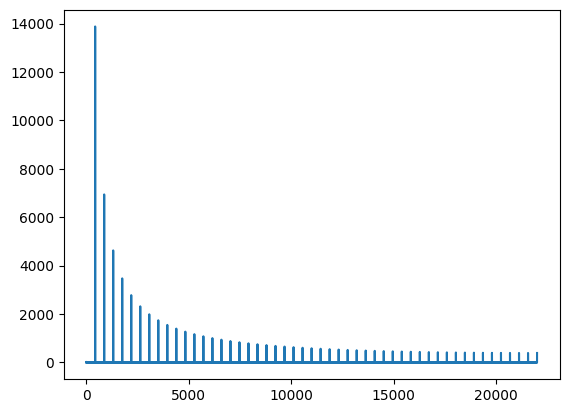

In [178]:
saw = SawtoothSignal().make_wave(framerate=44_000)
saw_spec = saw.make_spectrum()
saw_spec.plot()

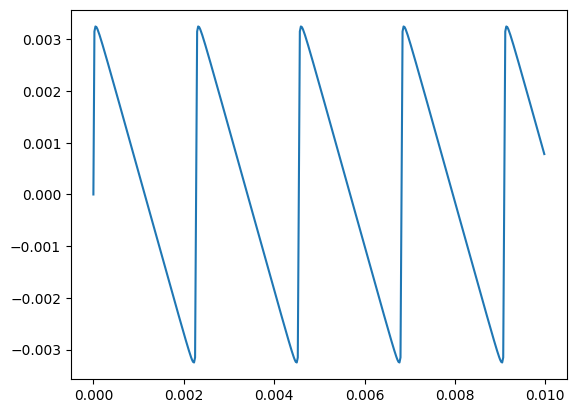

In [228]:
from thinkdsp import Sinusoid, SinSignal
base_freq = 440
sum_sig = Sinusoid(freq=base_freq, amp=1/base_freq)
for i in range(2, 101, 1):
    sum_sig += Sinusoid(freq=i*base_freq, amp=(1/(i*base_freq)))
sum_wave = sum_sig.make_wave(framerate=44_000)
sum_wave.segment(duration=.01).plot()